In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import sklearn.metrics
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
CELEB_IMS_DIR = '../data/celeba-hq/ims/'
CELEB_ANNO_DIR = '../data/celeba-hq/Anno/'
sys.path.append('transects')
import transects
# load and merge all the data
print('loading...')
df = data.load_ids()
labs, labs_full = data.load_labs()
for k in labs.keys():
    df[k] = labs[k].values
print('done loading!')

## show some frequent celebs

In [13]:
labs_full.keys()

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
d = df[df['count_with_this_id'] > 20]
d = d[d['skin-color'] == 0] # filter by skin color
# d = d[d['gender'] == 1] # filter by skin color

for i in d['id'].unique()[:20]:
    ids = d[d.id == i]
#     print(ids.shape)
    ims = np.array([mpimg.imread(oj(CELEB_IMS_DIR, fname))
                    for fname in ids.fname_final.values])
#     print(ims.shape)
    util.plot_row(ims)
    plt.show()

# look at image statistics

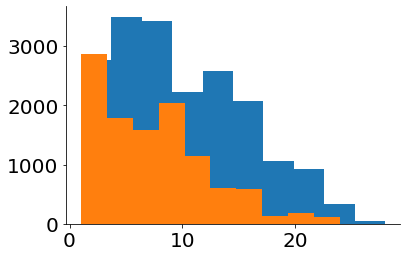

In [13]:
plt.hist(df[df['gender'] == 0]['count_with_this_id'], label='Female')
plt.hist(df[df['gender'] == 1]['count_with_this_id'], label='Male')
plt.show()
# plt.hist(df[df['gender'] == 1])

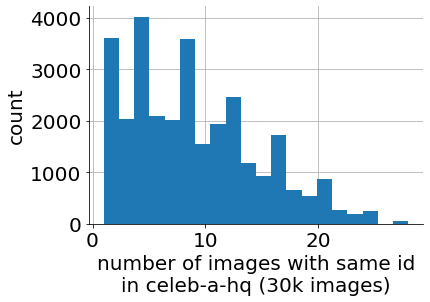

In [116]:
plt.grid(zorder=-1)
plt.hist(df['count_with_this_id'], bins=20, zorder=3)
plt.xlabel('number of images with same id\nin celeb-a-hq (30k images)')
plt.ylabel('count')
plt.show()

# latent-space matching

In [4]:
DIR_ORIG = '../data/celeba-hq/ims/'
# IM_NUMS = np.arange(1, 1301)

DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

latents = np.array([np.load(oj(DIR_GEN, f))
                    for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f])
print('shape', latents.shape)
coefs, intercepts = transects.get_directions()

shape (1403, 18, 512)


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

In [31]:
def get_lat(latents):
    lat = latents.mean(axis=1) # match in style space
    # lat = latents.reshape(latents.shape[0], -1) # match in extended style space
    return lat

def get_preds(coefs, intercepts):
    

def get_dists(lat):
    '''Get distances
    '''
    # calculate distances: (points, points)
    dists = sklearn.metrics.pairwise_distances(lat, metric='cosine') # cosine dist
    # dists = sklearn.metrics.pairwise_distances(lat, metric='l2') # cosine dist
    # sns.clustermap(dists)
    dists[np.eye(dists.shape[0]).astype(bool)] = 1e3 # don't pick same point
    # plt.imshow(dists)
    # dists_min = np.argmin(dists, axis=1)
    return dists

def show_matches(dists, DIR_ORIG, DIR_GEN):
    # pick the image
    im_nums = range(60, 70)
    for im_num in im_nums:
        R, C = 1, 7
        plt.figure(figsize=(C * 2, R * 2))

        plt.subplot(R, C, 1)
        im_orig = mpimg.imread(oj(DIR_ORIG, f'{im_num:05}.jpg'))
        util.imshow(im_orig)
        plt.title('original im', fontsize=10)

        plt.subplot(R, C, 2)
        im_rec = mpimg.imread(oj(DIR_GEN, f'{im_num:05}.png'))
        util.imshow(im_rec)
        plt.title('reconstruction', fontsize=10)

        closest_matches = np.argsort(dists[im_num - 1])
    #     print(dists[im_num - 1][closest_matches])
        plt.subplot(R, C, 3)
        plt.title('closest matches...', fontsize=10)
        for i in range(C - 2):
            plt.subplot(R, C, i + 3)
            matched_num = closest_matches[i] + 1
            im = mpimg.imread(oj(DIR_GEN, f'{matched_num:05}.png'))
            util.imshow(im)

lat = get_lat(latents)
dists = get_dists(lat)

## show matches for an im

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


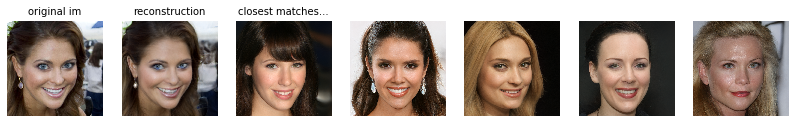

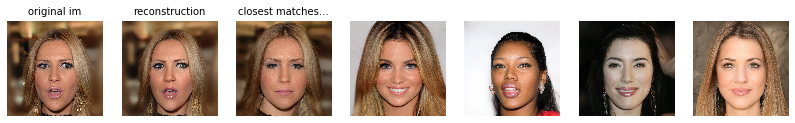

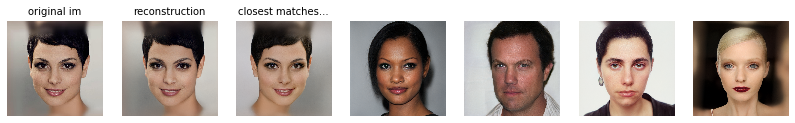

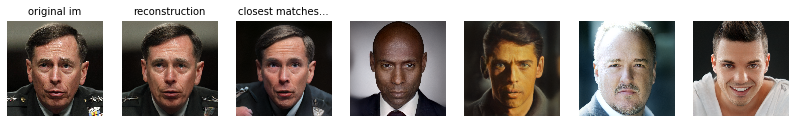

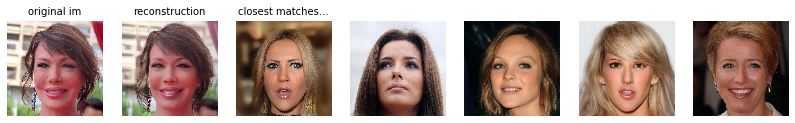

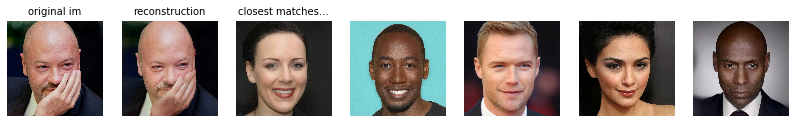

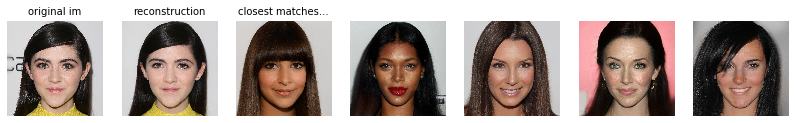

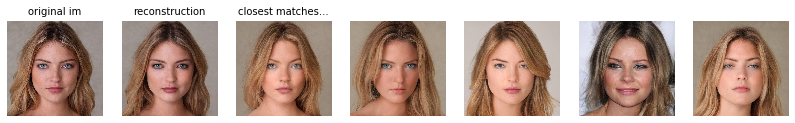

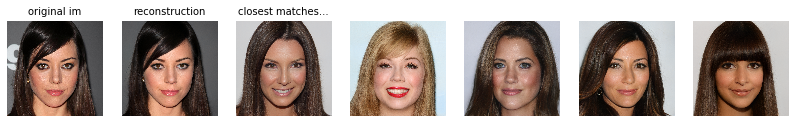

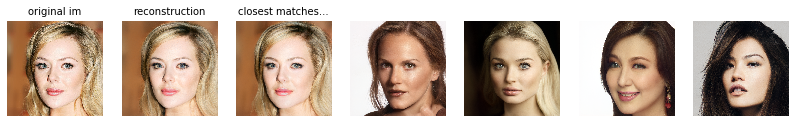

In [32]:
show_matches(dists, DIR_ORIG, DIR_GEN)